In [1]:
import numpy as np
import torch
import os 

import matplotlib
import matplotlib.pyplot as plt


# import corner
import seaborn as sns
sns.set()

In [7]:
print(os.getcwd())

/Users/ja.borowski/density-deconvolution-astro/notebooks


In [2]:
import sys
sys.path.append('/Users/ja.borowski/density-deconvolution-astro/')


In [3]:
device = torch.device("cpu")

# Create data

In [4]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

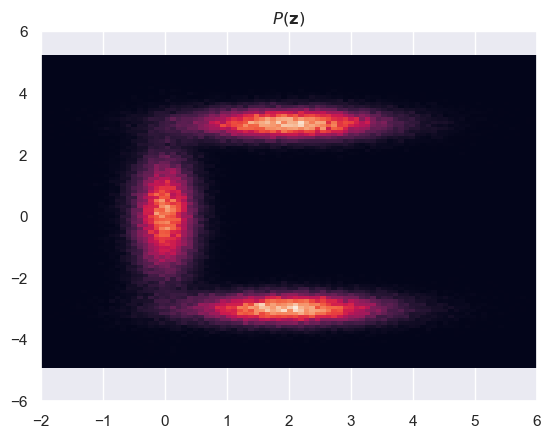

In [5]:
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
plt.hist2d(Z_train[:, 0].numpy(), Z_train[:, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$');

# Add error

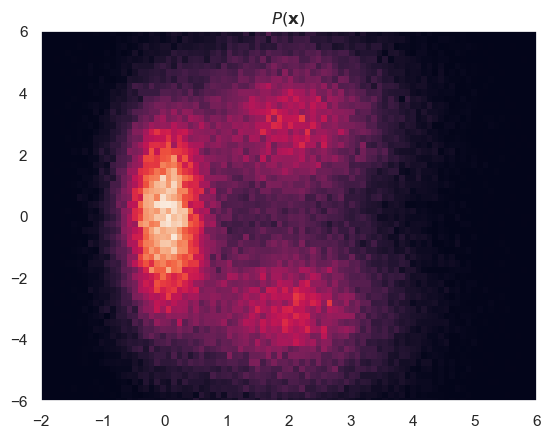

In [6]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
plt.hist2d(X_train[:, 0].numpy(), X_train[:, 1].numpy(), bins=100) #, ax=ax
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{x})$');

# Train 

In [7]:
from deconv.gmm.data import DeconvDataset

train_data = DeconvDataset(X_train, torch.linalg.cholesky(S.repeat(X_train.shape[0], 1, 1)))
test_data = DeconvDataset(X_test, torch.linalg.cholesky(S.repeat(X_test.shape[0], 1, 1)))

In [11]:
# from deconv.gmm.sgd_deconv_gmm import SGDDeconvGMM

# gmm = SGDDeconvGMM(
#     3,
#     2,
#     batch_size=200,
#     lr=1e-1,
#     epochs=100,
#     #device=torch.device('cpu')
# )
# gmm.fit(train_data, verbose=True)

In [8]:
# S.shape

In [12]:
from deconv.flow.svi import SVIFlow

svi = SVIFlow(
    2,
    5,
    device=torch.device("cpu"),
    batch_size=1,
    epochs=20,
    lr=1e-4,
    n_samples=50,
    use_iwae=True
)

In [14]:
%%time
svi.fit(train_data, val_data=None)

ValueError: Expected parameter loc (Tensor of shape (50, 2)) of distribution MultivariateNormal(loc: torch.Size([50, 2]), scale_tril: torch.Size([50, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<ExpandBackward0>)

/Users/ja.borowski/anaconda3/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  outputs, _ = torch.triangular_solve(


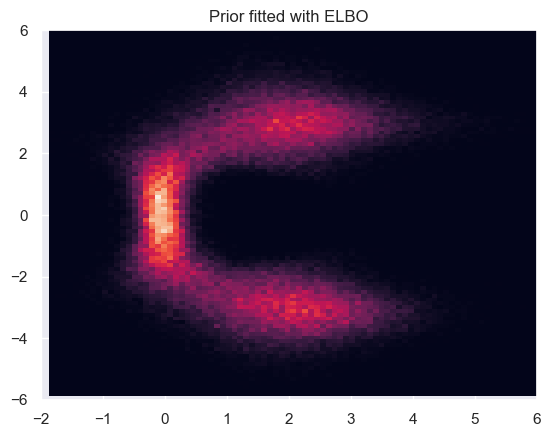

In [10]:
torch.set_default_tensor_type('torch.FloatTensor')
prior_samples = svi.sample_prior(100_000)

fig, ax = plt.subplots()
plt.hist2d(prior_samples[0, :, 0].numpy(), prior_samples[0, :, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Prior fitted with ELBO');

In [11]:
mean = np.array([[3.0, 0.0], [0.0, 0.0]])
cov = np.array([
    [
        [0.1, 0],
        [0, 3]
    ],
    [
        [0.1, 0],
        [0, 3]
    ]
])
test_point = [
    torch.Tensor(mean).to(svi.device),
    torch.cholesky(torch.Tensor(cov)).to(svi.device)
]
torch.set_default_tensor_type('torch.FloatTensor')
posterior_samples = svi.resample_posterior(test_point, 10000)

from deconv.gmm.plotting import plot_covariance
fig, ax = plt.subplots()
plt.hist2d(posterior_samples[0, :, 0].numpy(), posterior_samples[0, :, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Recognition network samples for test point, fitted using ELBO.');

/var/folders/y6/gpth_0zn2dl4hmv0ss28khb80000gp/T/ipykernel_941/2872830058.py:14: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1703.)
  torch.cholesky(torch.Tensor(cov)).to(svi.device)


TypeError: object of type 'generator' has no len()

In [19]:
rsamples = svi.resample_posterior(test_point, 10_000)

fig, ax = plt.subplots()
corner.hist2d(rsamples[0, :, 0].cpu().numpy(), rsamples[0, :, 1].cpu().numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Resampled posterior for test point, fitted using ELBO.')

TypeError: object of type 'generator' has no len()

In [1]:
importance = best_model.steps[1][1].feature_importances_
feature_names = X_train.columns

forest_importances = pd.Series(importance, index=feature_names)
# sort list of importances
sorted_importances = forest_importances.sort_values()
plt.bar(feature_names,importance)

# leve only features with importance > 0.01
to_keep = sorted_importances[sorted_importances > 0.01].index
X_train = X_train[to_keep]


NameError: name 'best_model' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score


f1_scorer = make_scorer(f1_score, average='macro')

pipeline = Pipeline([
        ('preproc', preproc),
        # add featrue selection 
        # ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier(sc))
    ])
# calcuate f1 score using defaind scorer
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f1_scorer)


# now remove features with low importance
# using score importance from a model 
# that was trained on all features
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# create a pipeline 
pipeline = Pipeline([
        ('preproc', preproc),
        # add featrue selection 
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier())
    ])
#get items from class 1 in training data 
